<a href="https://colab.research.google.com/github/hijyun/Overwatch-League-Prediction/blob/main/Prediction/df_final2_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 기본 패키지 설정

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import collections
import pandas as pd
from sklearn import datasets

from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier # 결정 트리
from sklearn.neighbors import KNeighborsClassifier # KNN
from sklearn.linear_model import LogisticRegression # 로지스틱 회귀

from sklearn.ensemble import VotingClassifier,RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier # 앙상블 

from sklearn.metrics import confusion_matrix, classification_report # 정오분류표
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score 
from sklearn.metrics import roc_curve, auc, roc_auc_score  # ROC곡선 그리기

from sklearn.model_selection import learning_curve, validation_curve # 학습곡선, 검증곡선
from sklearn.model_selection import GridSearchCV, cross_val_score  # 하이퍼파라미터 튜닝, 교차타당도

In [7]:
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

# 데이터 읽기

In [8]:
df1 = pd.read_csv('https://raw.githubusercontent.com/hijyun/Overwatch-League-Prediction/main/preprocessing/df_final2.csv')

In [9]:
df1.head()

,Unnamed: 0,esports_match_id,map_name,team_name,win,Damage,Healing,Kill,Death,Barrier,Eliminations,Final Blows,Healing Received,Damage Blocked,Damage Taken,Ultimates Earned - Fractional,Ultimates Negated,Ultimates Used,Assists,Defensive Assists,Offensive Assists,Time Played
0,0,30991,Eichenwalde,Paris Eternal,0,562240.779110,102994.122865,210.0,106.0,93901.40980,262,86,34021.82845,143348.93450,107667.45130,101.710336,0.0,72,170.0,90.0,86.0,11785.838170
1,1,30991,Eichenwalde,Toronto Defiant,1,628126.701027,119825.020513,313.0,102.0,143348.93450,322,102,41520.14098,127360.63980,121061.94270,102.592067,0.0,94,218.0,78.0,114.0,11785.838170
2,2,30991,Havana,Paris Eternal,0,369505.598781,69563.366620,138.0,118.0,49429.29399,156,56,22974.73930,88845.75708,84555.76886,66.336034,0.0,58,98.0,52.0,62.0,8631.732713
3,3,30991,Havana,Toronto Defiant,1,438383.607557,78776.610181,337.0,60.0,88845.75709,344,118,28430.25998,63075.42223,85702.02986,78.189298,1.0,72,226.0,108.0,98.0,8631.732713
4,4,30991,Horizon Lunar Colony,Paris Eternal,0,438116.899123,90377.982786,207.0,92.0,57440.94655,294,98,28632.82346,87504.85590,92947.47734,78.837408,0.0,60,196.0,110.0,114.0,9881.643794


In [10]:
X = df1.drop(['win','map_name','esports_match_id','Unnamed: 0','team_name'], axis=1)
y = df1['win']

In [11]:
df1.shape

(2246, 22)

In [12]:
df1.head()

,Unnamed: 0,esports_match_id,map_name,team_name,win,Damage,Healing,Kill,Death,Barrier,Eliminations,Final Blows,Healing Received,Damage Blocked,Damage Taken,Ultimates Earned - Fractional,Ultimates Negated,Ultimates Used,Assists,Defensive Assists,Offensive Assists,Time Played
0,0,30991,Eichenwalde,Paris Eternal,0,562240.779110,102994.122865,210.0,106.0,93901.40980,262,86,34021.82845,143348.93450,107667.45130,101.710336,0.0,72,170.0,90.0,86.0,11785.838170
1,1,30991,Eichenwalde,Toronto Defiant,1,628126.701027,119825.020513,313.0,102.0,143348.93450,322,102,41520.14098,127360.63980,121061.94270,102.592067,0.0,94,218.0,78.0,114.0,11785.838170
2,2,30991,Havana,Paris Eternal,0,369505.598781,69563.366620,138.0,118.0,49429.29399,156,56,22974.73930,88845.75708,84555.76886,66.336034,0.0,58,98.0,52.0,62.0,8631.732713
3,3,30991,Havana,Toronto Defiant,1,438383.607557,78776.610181,337.0,60.0,88845.75709,344,118,28430.25998,63075.42223,85702.02986,78.189298,1.0,72,226.0,108.0,98.0,8631.732713
4,4,30991,Horizon Lunar Colony,Paris Eternal,0,438116.899123,90377.982786,207.0,92.0,57440.94655,294,98,28632.82346,87504.85590,92947.47734,78.837408,0.0,60,196.0,110.0,114.0,9881.643794


In [13]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2246 entries, 0 to 2245
Data columns (total 22 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Unnamed: 0                     2246 non-null   int64  
 1   esports_match_id               2246 non-null   int64  
 2   map_name                       2246 non-null   object 
 3   team_name                      2246 non-null   object 
 4   win                            2246 non-null   int64  
 5   Damage                         2246 non-null   float64
 6   Healing                        2246 non-null   float64
 7   Kill                           2246 non-null   float64
 8   Death                          2246 non-null   float64
 9   Barrier                        2246 non-null   float64
 10  Eliminations                   2246 non-null   int64  
 11  Final Blows                    2246 non-null   int64  
 12  Healing Received               2246 non-null   f

In [14]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2246 entries, 0 to 2245
Data columns (total 17 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Damage                         2246 non-null   float64
 1   Healing                        2246 non-null   float64
 2   Kill                           2246 non-null   float64
 3   Death                          2246 non-null   float64
 4   Barrier                        2246 non-null   float64
 5   Eliminations                   2246 non-null   int64  
 6   Final Blows                    2246 non-null   int64  
 7   Healing Received               2246 non-null   float64
 8   Damage Blocked                 2246 non-null   float64
 9   Damage Taken                   2246 non-null   float64
 10  Ultimates Earned - Fractional  2246 non-null   float64
 11  Ultimates Negated              2246 non-null   float64
 12  Ultimates Used                 2246 non-null   i

# 전처리 및 데이터 분할

In [15]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()       # 범주형 변수를 0부터 시작하는 정수형 숫자로 변환
y = le.fit_transform(y)   


In [16]:
y

array([0, 1, 0, ..., 1, 0, 1])

## train data , test data split

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=100, stratify=y)

# 모델

In [34]:
logistic = LogisticRegression(solver='liblinear',penalty='l2',C= 0.1,random_state=1)
tree = DecisionTreeClassifier(max_depth=4,criterion='entropy',random_state=1)
knn = KNeighborsClassifier(n_neighbors=4,p=2,metric='minkowski')

voting_estimators = [('logistic', logistic), ('tree', tree), ('knn', knn)]

voting = VotingClassifier(estimators = voting_estimators,voting='soft')

forest = RandomForestClassifier(criterion='entropy',n_estimators=700,random_state=1)
lgb = LGBMClassifier(random_state=42)
xgb = XGBClassifier(tree_method='hist',random_state=41)

adaboost = AdaBoostClassifier(base_estimator=tree, 
                                n_estimators=100,
                                learning_rate = 0.01, 
                                random_state=42)
clf_labels = ['Logistic regression', 'Decision tree',  'Majority voting','Random forest','Ada boost','XGB','LIGHTGBM',"KNN"]

all_clf = [logistic, tree, voting, forest,adaboost,xgb,lgb,knn]

### AUC 검정

In [ ]:
for clf, label in zip(all_clf, clf_labels):
  scores = cross_val_score(estimator=clf,X=X_train,y=y_train,cv=10,scoring='roc_auc')
  print("ROC AUC: %0.3f (+/- %0.3f) [%s]"
  % (scores.mean(), scores.std(), label))

ROC AUC: 0.967 (+/- 0.011) [Logistic regression]
ROC AUC: 0.954 (+/- 0.011) [Decision tree]
ROC AUC: 0.967 (+/- 0.011) [Majority voting]


### ROC 커브

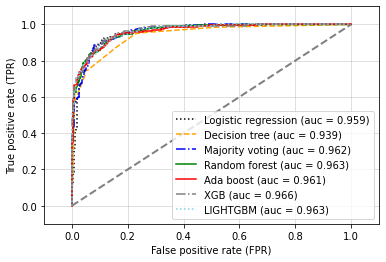

In [20]:
colors = ['black', 'orange', 'blue', 'green','red','gray','skyblue']
linestyles = [':', '--', '-.', '-','solid','dashdot','dotted']
for clf, label, clr, ls \
        in zip(all_clf, clf_labels, colors, linestyles):

  clf.fit(X_train, y_train)
  y_pred = clf.predict_proba(X_test)[:, 1]
  fpr, tpr, thresholds = roc_curve(y_true=y_test,
                                  y_score=y_pred)
  roc_auc = auc(x=fpr, y=tpr) # 교차검증 X
  plt.plot(fpr, tpr,
            color=clr,
            linestyle=ls,
            label='%s (auc = %0.3f)' % (label, roc_auc))
  
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1],
          linestyle='--',
          color='gray',
          linewidth=2)

plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid(alpha=0.5)
plt.xlabel('False positive rate (FPR)')
plt.ylabel('True positive rate (TPR)')

plt.show()

### 정오 분류표로 검정

## voting

In [21]:
voting.fit(X_train, y_train)
y_pred = voting.predict(X_test)

print('잘못 분류된 샘플 개수: %d' % (y_test != y_pred).sum())
print('정확도: %.3f' % accuracy_score(y_test, y_pred))
print('정밀도: %.3f' % precision_score(y_true=y_test, y_pred=y_pred))
print('재현율: %.3f' % recall_score(y_true=y_test, y_pred=y_pred))
print('F1: %.3f' % f1_score(y_true=y_test, y_pred=y_pred))

잘못 분류된 샘플 개수: 71
정확도: 0.895
정밀도: 0.901
재현율: 0.887
F1: 0.894


# 모수 튜닝

## voting

In [22]:
voting.get_params()

{'estimators': [('logistic',
   LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                      intercept_scaling=1, l1_ratio=None, max_iter=100,
                      multi_class='auto', n_jobs=None, penalty='l2',
                      random_state=1, solver='liblinear', tol=0.0001, verbose=0,
                      warm_start=False)),
  ('tree',
   DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                          max_depth=4, max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, presort='deprecated',
                          random_state=1, splitter='best')),
  ('knn',
   KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                        metric_params=None, n_jobs=None, n_neighbors=41, p=2,
        

In [23]:
parms = {'logistic__C':[0.001,0.1,100.0],
         'tree__max_depth' :  [1,2,3,4,5],
         'knn__n_neighbors':[1,2,3,4,5]}


grid = GridSearchCV(estimator=voting, 
                    param_grid=parms,
                    cv=10,
                    scoring='roc_auc',
                    iid=False)




In [24]:
grid.fit(X_train,y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


GridSearchCV(cv=10, error_score=nan,
             estimator=VotingClassifier(estimators=[('logistic',
                                                     LogisticRegression(C=0.1,
                                                                        class_weight=None,
                                                                        dual=False,
                                                                        fit_intercept=True,
                                                                        intercept_scaling=1,
                                                                        l1_ratio=None,
                                                                        max_iter=100,
                                                                        multi_class='auto',
                                                                        n_jobs=None,
                                                                        penalty='l2',
                       

In [25]:
for r, _ in enumerate(grid.cv_results_['mean_test_score']):
  print("%0.3f +/- %0.3f %r" % (grid.cv_results_['mean_test_score'][r],
        grid.cv_results_['std_test_score'][r] / 2.0,
        grid.cv_results_['params'][r]))


0.909 +/- 0.015 {'knn__n_neighbors': 1, 'logistic__C': 0.001, 'tree__max_depth': 1}
0.933 +/- 0.010 {'knn__n_neighbors': 1, 'logistic__C': 0.001, 'tree__max_depth': 2}
0.946 +/- 0.006 {'knn__n_neighbors': 1, 'logistic__C': 0.001, 'tree__max_depth': 3}
0.950 +/- 0.007 {'knn__n_neighbors': 1, 'logistic__C': 0.001, 'tree__max_depth': 4}
0.951 +/- 0.007 {'knn__n_neighbors': 1, 'logistic__C': 0.001, 'tree__max_depth': 5}
0.910 +/- 0.014 {'knn__n_neighbors': 1, 'logistic__C': 0.1, 'tree__max_depth': 1}
0.934 +/- 0.010 {'knn__n_neighbors': 1, 'logistic__C': 0.1, 'tree__max_depth': 2}
0.948 +/- 0.006 {'knn__n_neighbors': 1, 'logistic__C': 0.1, 'tree__max_depth': 3}
0.951 +/- 0.007 {'knn__n_neighbors': 1, 'logistic__C': 0.1, 'tree__max_depth': 4}
0.952 +/- 0.007 {'knn__n_neighbors': 1, 'logistic__C': 0.1, 'tree__max_depth': 5}
0.910 +/- 0.014 {'knn__n_neighbors': 1, 'logistic__C': 100.0, 'tree__max_depth': 1}
0.933 +/- 0.010 {'knn__n_neighbors': 1, 'logistic__C': 100.0, 'tree__max_depth': 2}
0.

In [26]:
print('최적의 파타미터: %s' % grid.best_params_)
print('ACU: %.3f' % grid.best_score_)


최적의 파타미터: {'knn__n_neighbors': 4, 'logistic__C': 0.1, 'tree__max_depth': 4}
ACU: 0.967


## Bagging

In [27]:
forest.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'entropy',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 700,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}

In [28]:
parms = {'n_estimators':[100],
         'max_depth' :  [6,8,10,12],
         'min_samples_leaf':[3,5,7,10],
         'min_samples_split': [2,3,5,10]}


grid = GridSearchCV(estimator=forest, 
                    param_grid=parms,
                    cv=10,
                    scoring='roc_auc',
                    iid=False)

In [29]:
grid.fit(X_train,y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


GridSearchCV(cv=10, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='entropy',
                                              max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=700, n_jobs=None,
                                              oob_score=False, r

In [30]:

for r, _ in enumerate(grid.cv_results_['mean_test_score']):
  print("%0.3f +/- %0.3f %r" % (grid.cv_results_['mean_test_score'][r],
        grid.cv_results_['std_test_score'][r] / 2.0,
        grid.cv_results_['params'][r]))

0.963 +/- 0.005 {'max_depth': 6, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 100}
0.963 +/- 0.005 {'max_depth': 6, 'min_samples_leaf': 3, 'min_samples_split': 3, 'n_estimators': 100}
0.963 +/- 0.005 {'max_depth': 6, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 100}
0.963 +/- 0.005 {'max_depth': 6, 'min_samples_leaf': 3, 'min_samples_split': 10, 'n_estimators': 100}
0.963 +/- 0.005 {'max_depth': 6, 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 100}
0.963 +/- 0.005 {'max_depth': 6, 'min_samples_leaf': 5, 'min_samples_split': 3, 'n_estimators': 100}
0.963 +/- 0.005 {'max_depth': 6, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 100}
0.963 +/- 0.005 {'max_depth': 6, 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 100}
0.963 +/- 0.005 {'max_depth': 6, 'min_samples_leaf': 7, 'min_samples_split': 2, 'n_estimators': 100}
0.963 +/- 0.005 {'max_depth': 6, 'min_samples_leaf': 7, 'min_samples_split': 3, 'n_estima

In [31]:
print('최적의 파타미터: %s' % grid.best_params_)
print('ACU: %.3f' % grid.best_score_)

최적의 파타미터: {'max_depth': 8, 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 100}
ACU: 0.963
